In [1]:
module O

function chisq_test_for_risk_ratio(data; null=1, siglev=0.05)
    pvalue = pvalue_rr_pearson_chisq(data'...; ρ=null)
    riskratiohat = _riskratiohat(data'...)
    confint = confint_rr_pearson_chisq(data'...; α=siglev)
    
    print("Pearson's chi-squared test for risk ratio\n")
    print("  data: ", data, "\n")
    print("  null hypothesis: risk ratio = ", null, "\n")
    print("  P-value: ", round(pvalue; sigdigits=4), "\n")
    print("  point estimate of risk ratio: ",
        round(riskratiohat; sigdigits=4), "\n")
    print("  $(100(1 - siglev))% confidence interval of risk ratio: ",
        round.(confint; sigdigits=4), "\n")
end

using Distributions
using Roots
using StatsFuns

safemul(x, y) = x==0 ? zero(x/y) : x*y
safediv(x, y) = x==0 ? zero(x/y) : x/y

_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end

end

Main.O

In [2]:
res = O.chisq_test_for_risk_ratio([5 1; 1 4])

Pearson's chi-squared test for risk ratio
  data: [5 1; 1 4]
  null hypothesis: risk ratio = 1
  P-value: 0.03568
  point estimate of risk ratio: 4.167
  95.0% confidence interval of risk ratio: [1.083, 23.49]


In [3]:
module O

@kwdef struct Chisq2x2RiskRatio{D, N, P, R, L, I}
    data::D
    null::N
    pvalue::P
    riskratiohat::R
    siglev::L
    confint::I
end

function chisq_test_for_risk_ratio(data; null=1, siglev=0.05)
    pvalue = pvalue_rr_pearson_chisq(data'...; ρ=null)
    riskratiohat = _riskratiohat(data'...)
    confint = confint_rr_pearson_chisq(data'...; α=siglev)
    Chisq2x2RiskRatio(data, null, pvalue, riskratiohat, siglev, confint)
end

function Base.show(io::IO, ::MIME"text/plain", x::Chisq2x2RiskRatio)
    (; data, null, pvalue, riskratiohat, siglev, confint) = x
    print(io, "Pearson's chi-squared test for risk ratio\n")
    print(io, "  data: ", data, "\n")
    print(io, "  null hypothesis: risk ratio = ", null, "\n")
    print(io, "  P-value: ", round(pvalue; sigdigits=4), "\n")
    print(io, "  point estimate of risk ratio: ",
        round(riskratiohat; sigdigits=4), "\n")
    print(io, "  $(100(1 - siglev))% confidence interval of risk ratio: ",
        round.(confint; sigdigits=4), "\n")
end

Base.:(==)(x::Chisq2x2RiskRatio, y::Chisq2x2RiskRatio) =
    all(fieldnames(Chisq2x2RiskRatio)) do k
        getproperty(x, k) == getproperty(y, k)
    end

function Base.show(io::IO, x::Chisq2x2RiskRatio)
    (; data, null, pvalue, riskratiohat, siglev, confint) = x
    print(io,
        "Chisq2x2RiskRatio(",
        "data=", data, ", ",
        "null=", null, ", ",
        "pvalue=", pvalue, ", ",
        "riskratiohat=", riskratiohat, ", ",
        "siglev=", siglev, ", ",
        "confint=", confint, ")")
end

using Distributions
using Roots
using StatsFuns

safemul(x, y) = x==0 ? zero(x/y) : x*y
safediv(x, y) = x==0 ? zero(x/y) : x/y

_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end

end

Main.O

In [4]:
res = O.chisq_test_for_risk_ratio([5 1; 1 4])

Pearson's chi-squared test for risk ratio
  data: [5 1; 1 4]
  null hypothesis: risk ratio = 1
  P-value: 0.03568
  point estimate of risk ratio: 4.167
  95.0% confidence interval of risk ratio: [1.083, 23.49]


In [5]:
dump(res)

Main.O.Chisq2x2RiskRatio{Matrix{Int64}, Int64, Float64, Float64, Float64, Vector{Float64}}
  data: Array{Int64}((2, 2)) [5 1; 1 4]
  null: Int64 1
  pvalue: Float64 0.03568232934330229
  riskratiohat: Float64 4.166666666666667
  siglev: Float64 0.05
  confint: Array{Float64}((2,)) [1.0834832527817053, 23.48555999095307]


In [6]:
show(res)

Chisq2x2RiskRatio(data=[5 1; 1 4], null=1, pvalue=0.03568232934330229, riskratiohat=4.166666666666667, siglev=0.05, confint=[1.0834832527817053, 23.48555999095307])

In [7]:
string(res)

"Chisq2x2RiskRatio(data=[5 1; 1 4], null=1, pvalue=0.03568232934330229, riskratiohat=4.166666666666667, siglev=0.05, confint=[1.0834832527817053, 23.48555999095307])"

In [8]:
res2 = eval(Meta.parse("O." * string(res)))

Pearson's chi-squared test for risk ratio
  data: [5 1; 1 4]
  null hypothesis: risk ratio = 1
  P-value: 0.03568
  point estimate of risk ratio: 4.167
  95.0% confidence interval of risk ratio: [1.083, 23.49]


In [9]:
res == res2

true

In [10]:
using StatsPlots

log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α = 0.05)) = [0.03482220289099799, 1.3708009199836646]


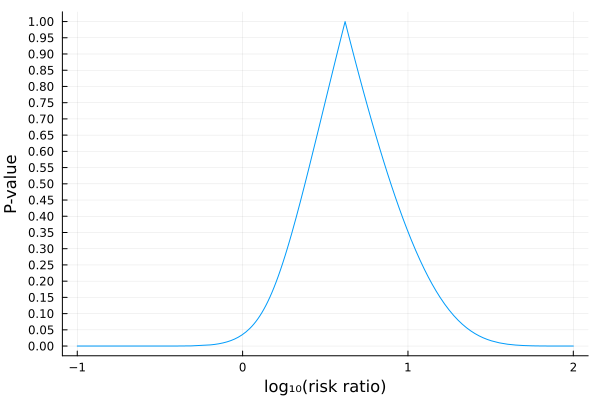

Pearson's chi-squared test for risk ratio
  data: [5 1; 1 4]
  null hypothesis: risk ratio = 1
  P-value: 0.03568
  point estimate of risk ratio: 4.167
  95.0% confidence interval of risk ratio: [1.083, 23.49]


In [11]:
A = [5 1; 1 4]
@show log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α=0.05))
plot(x -> O.pvalue_rr_pearson_chisq(A'...; ρ=10^x), -1, 2;
    label="", ylim=(-0.03, 1.03), xguide="log₁₀(risk ratio)", yguide="P-value",
    ytick=0:0.05:1) |> display
res = O.chisq_test_for_risk_ratio(A)

log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α = 0.05)) = [-Inf, Inf]


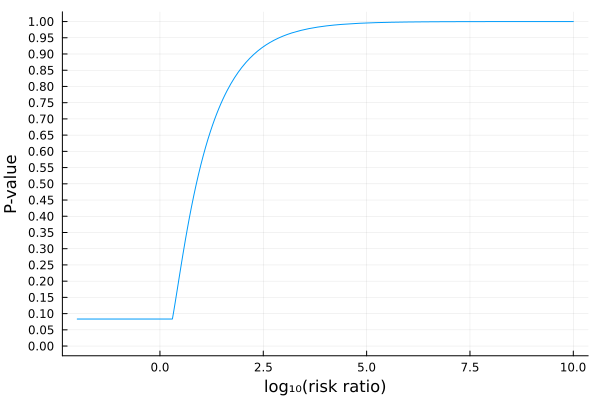

Pearson's chi-squared test for risk ratio
  data: [3 0; 0 3]
  null hypothesis: risk ratio = 1
  P-value: 0.08326
  point estimate of risk ratio: Inf
  95.0% confidence interval of risk ratio: [0.0, Inf]


In [12]:
A = [3 0; 0 3]
@show log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α=0.05))
plot(x -> O.pvalue_rr_pearson_chisq(A'...; ρ=10^x), -2, 10;
    label="", ylim=(-0.03, 1.03), xguide="log₁₀(risk ratio)", yguide="P-value",
    ytick=0:0.05:1) |> display
res = O.chisq_test_for_risk_ratio(A)

log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α = 0.05)) = [-Inf, 7.061988160736172]


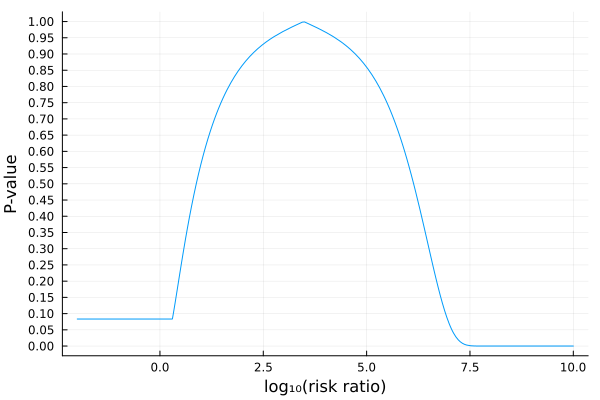

Pearson's chi-squared test for risk ratio
  data: [3.0 0.0; 0.001 3.0]
  null hypothesis: risk ratio = 1
  P-value: 0.08337
  point estimate of risk ratio: 3001.0
  95.0% confidence interval of risk ratio: [0.0, 1.153e7]


In [13]:
A = [3 0; 0.001 3]
@show log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α=0.05))
plot(x -> O.pvalue_rr_pearson_chisq(A'...; ρ=10^x), -2, 10;
    label="", ylim=(-0.03, 1.03), xguide="log₁₀(risk ratio)", yguide="P-value",
    ytick=0:0.05:1) |> display
res = O.chisq_test_for_risk_ratio(A)

log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α = 0.05)) = [-Inf, 0.6132262521015341]


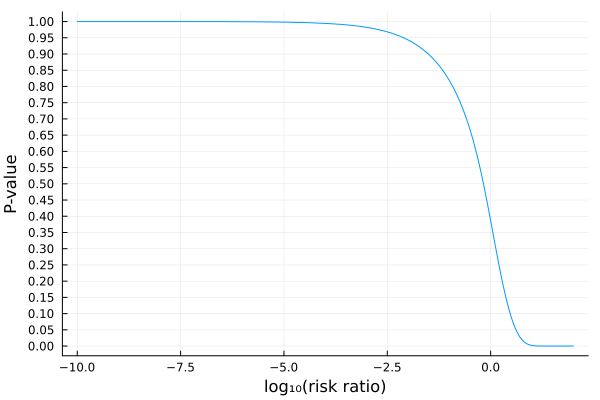

Pearson's chi-squared test for risk ratio
  data: [0 1; 1 1]
  null hypothesis: risk ratio = 1
  P-value: 0.3865
  point estimate of risk ratio: 0.0
  95.0% confidence interval of risk ratio: [0.0, 4.104]


In [14]:
A = [0 1; 1 1]
@show log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α=0.05))
plot(x -> O.pvalue_rr_pearson_chisq(A'...; ρ=10^x), -10, 2;
    label="", ylim=(-0.03, 1.03), xguide="log₁₀(risk ratio)", yguide="P-value",
    ytick=0:0.05:1) |> display
res = O.chisq_test_for_risk_ratio(A)

log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α = 0.05)) = [-8.28355393451941, 0.6132726149091758]


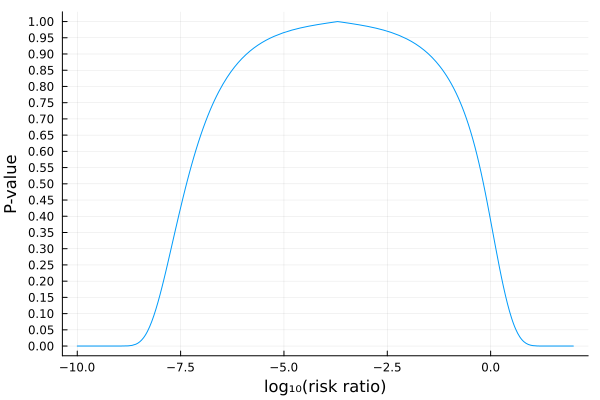

Pearson's chi-squared test for risk ratio
  data: [0.0001 1.0; 1.0 1.0]
  null hypothesis: risk ratio = 1
  P-value: 0.3866
  point estimate of risk ratio: 0.0002
  95.0% confidence interval of risk ratio: [5.205e-9, 4.105]


In [15]:
A = [0.0001 1; 1 1]
@show log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α=0.05))
plot(x -> O.pvalue_rr_pearson_chisq(A'...; ρ=10^x), -10, 2;
    label="", ylim=(-0.03, 1.03), xguide="log₁₀(risk ratio)", yguide="P-value",
    ytick=0:0.05:1) |> display
res = O.chisq_test_for_risk_ratio(A)

log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α = 0.05)) = [-0.6132262521015347, Inf]


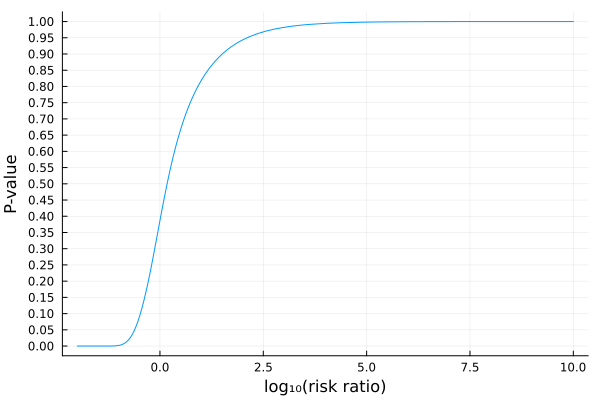

Pearson's chi-squared test for risk ratio
  data: [1 1; 0 1]
  null hypothesis: risk ratio = 1
  P-value: 0.3865
  point estimate of risk ratio: Inf
  95.0% confidence interval of risk ratio: [0.2437, Inf]


In [16]:
A = [1 1; 0 1]
@show log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α=0.05))
plot(x -> O.pvalue_rr_pearson_chisq(A'...; ρ=10^x), -2, 10;
    label="", ylim=(-0.03, 1.03), xguide="log₁₀(risk ratio)", yguide="P-value",
    ytick=0:0.05:1) |> display
res = O.chisq_test_for_risk_ratio(A)

log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α = 0.05)) = [-0.6132726149091756, 8.283553934519515]


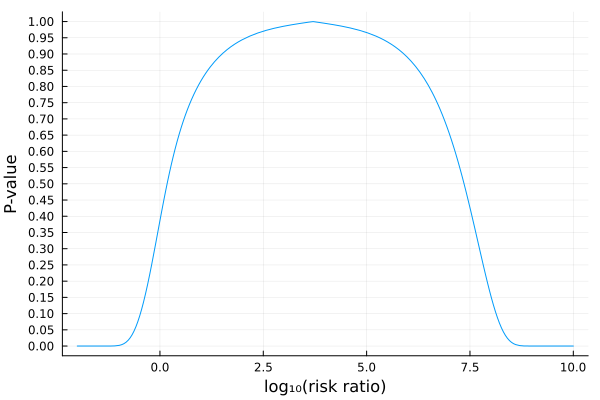

Pearson's chi-squared test for risk ratio
  data: [1.0 1.0; 0.0001 1.0]
  null hypothesis: risk ratio = 1
  P-value: 0.3866
  point estimate of risk ratio: 5000.0
  95.0% confidence interval of risk ratio: [0.2436, 1.921e8]


In [17]:
A = [1 1; 0.0001 1]
@show log₁₀ci = log10.(O.confint_rr_pearson_chisq(A'...; α=0.05))
plot(x -> O.pvalue_rr_pearson_chisq(A'...; ρ=10^x), -2, 10;
    label="", ylim=(-0.03, 1.03), xguide="log₁₀(risk ratio)", yguide="P-value",
    ytick=0:0.05:1) |> display
res = O.chisq_test_for_risk_ratio(A)